In [1]:
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import gzip
import re
import json

In [3]:
def parse_line(l):
    if l[0] == '#': 
        return None
    if len(l) < 33:
        #print("ERROR: "+l)
        return None
    return {
        "task": re.sub("^ *", "", l[0:16]),
        "pid": int(re.sub(" +$", "", l[17:22])),
        "cpu": int(l[24:27]),
        "irq_off": l[29],
        "need_resched": l[30],
        "hardirq_softirq": l[31],
        "preempt_depth": int(l[32]),
        "timestamp": float(l[33:45]),
        "function": re.sub(":.*", "", l[48:])[:-1],
        "arguments": re.sub("[^:]+:", "", l[48:])[:-1]
    }

In [4]:
def load_log(tracefile):
    with gzip.open(tracefile) as f:
        return [
            line for line in [
            parse_line(line.decode()) 
            for line 
            in f
            ] if line != None
        ]

In [5]:
def query_state(trace):
    return [
        [line["timestamp"], 1 if re.match(".*(SQL_START|BDB_START|DELAY_end)", line["arguments"]) else 0, line["arguments"]]
        for line in trace
        if re.match(".*(DELAY_|SQL_|BDB_)", line["arguments"])
        and line["function"] == "tracing_mark_write"
        and line["task"] == "chmark_withjson"
    ]

In [6]:
def compute_deltas(trace):
    state_changes = query_state(trace)
    state_on = state_changes[0::2]
    state_off = state_changes[1::2]
    assert( len([x for x in state_on if x[1] != 1]) == 0)
    assert( len([x for x in state_off if x[1] != 0]) == 0)
    start_time = state_on[0][0]
    state_pairs = zip([x[0] for x in state_on], [x[0] for x in state_off])
    return [
        (x[0]-start_time, x[1]-x[0])
        for x in state_pairs
    ]

In [7]:
def load_ops(opsfile):
    with open(opsfile) as f:
        benchmark = json.load(f)["benchmark"]
        return zip(
            range(0, len(benchmark)),
            [
                ( x["sql"].split(" ")[0] )
                for x in benchmark
                if x["op"] == "query"
            ]
        )


In [8]:
def load_ops_by_category(opsfile):
    result = {}
    for idx, event in load_ops(opsfile):
        if event not in result:
            result[event] = []
        result[event] += [ (idx, len(result[event])) ]
    return result
    
load_ops_by_category("../files/json/log_timing/workload_a_timing_a.json")

{'SELECT': [(0, 0),
  (2, 1),
  (3, 2),
  (5, 3),
  (6, 4),
  (9, 5),
  (11, 6),
  (15, 7),
  (16, 8),
  (17, 9),
  (18, 10),
  (21, 11),
  (23, 12),
  (25, 13),
  (30, 14),
  (32, 15),
  (35, 16),
  (39, 17),
  (40, 18),
  (41, 19),
  (42, 20),
  (44, 21),
  (47, 22),
  (48, 23),
  (51, 24),
  (52, 25),
  (54, 26),
  (55, 27),
  (57, 28),
  (58, 29),
  (59, 30),
  (63, 31),
  (64, 32),
  (68, 33),
  (71, 34),
  (73, 35),
  (74, 36),
  (78, 37),
  (84, 38),
  (86, 39),
  (87, 40),
  (88, 41),
  (90, 42),
  (91, 43),
  (93, 44),
  (95, 45),
  (97, 46),
  (98, 47),
  (100, 48),
  (102, 49),
  (104, 50),
  (110, 51),
  (111, 52),
  (112, 53),
  (113, 54),
  (114, 55),
  (117, 56),
  (119, 57),
  (120, 58),
  (121, 59),
  (127, 60),
  (128, 61),
  (129, 62),
  (130, 63),
  (132, 64),
  (133, 65),
  (134, 66),
  (135, 67),
  (136, 68),
  (137, 69),
  (139, 70),
  (140, 71),
  (141, 72),
  (145, 73),
  (146, 74),
  (152, 75),
  (153, 76),
  (157, 77),
  (158, 78),
  (167, 79),
  (168, 80),
 

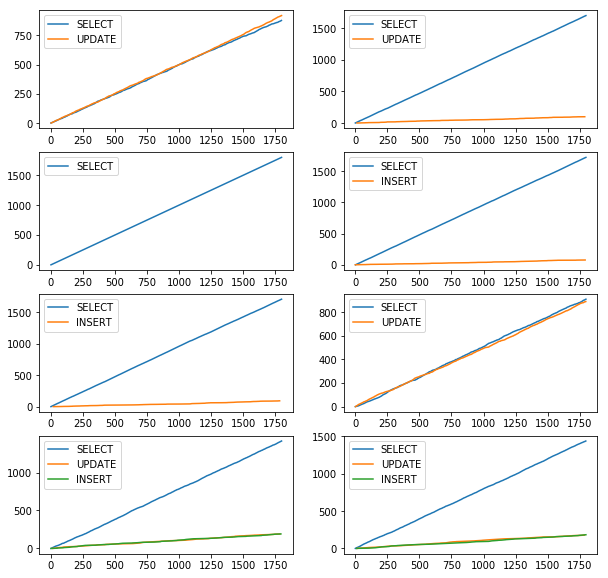

In [9]:
def plot_ops(opsfile, ax = None):
    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ops = load_ops_by_category(opsfile)
    for event in ops:
        points = ops[event]
        scale = float(points[-1][1])
        ax.plot(
            [x[0] for x in points],
            [x[1] for x in points],
            label = event
        )
    ax.legend()

opsfiles = [
    "../files/json/log_timing/workload_"+x+"_timing_a.json"
    for x in ["a","b","c","d","e","f","ib","ic"]
]

fig = plt.figure(figsize = (10,10))
for i, opsfile in zip(range(0, len(opsfiles)), opsfiles):
    ax = fig.add_subplot(421+i)
    plot_ops(opsfile, ax)


In [10]:
def reduce(arr):
    result = {}
    for k, v in arr:
        if k not in result:
            result[k] = []
        result[k] += [v]
    return result

In [12]:
def label_deltas(deltas, opsfile):
    deltas = zip(load_ops(opsfile), deltas, range(0, len(deltas)))
    return reduce([
        (x[0][1], (x[2],x[1][1]))
        for x in deltas
    ])

In [13]:
def plot_workload_deltas(deltas, opsfile, workload_title, save_file = None):
    fig = plt.figure( figsize = (12, 8) )
    for i in range(0,6):
        ax = fig.add_subplot(321+i)
        ax.semilogy()
        ax.set_ylim(4e-4,2e-1)
        if i >= 4:
            ax.set_xlabel("Query Index")
        else:
            ax.get_xaxis().set_visible(False)
        if i % 2 == 0:
            ax.set_ylabel("Latency (s)")
        title = all_governors[i].title()+" Governor"
        ax.set_title(title)
        labeled_deltas = label_deltas(deltas[i], opsfile)
        for q in labeled_deltas:
            ax.scatter(
                [x[0] for x in labeled_deltas[q]],
                [x[1] for x in labeled_deltas[q]],
                s=10, label = q, marker = ('+' if q == "SELECT" else 'x')
            )
        ax.legend()
    fig.suptitle(workload_title)
    if save_file != None:
        fig.savefig(save_file, bbox_inches='tight')

In [14]:
all_governors = ["conservative", "interactive", "ondemand", "performance", "powersave", "userspace"]

In [45]:
A_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadA_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [46]:
A_log_deltas = [compute_deltas(x[1]) for x in A_log_traces]

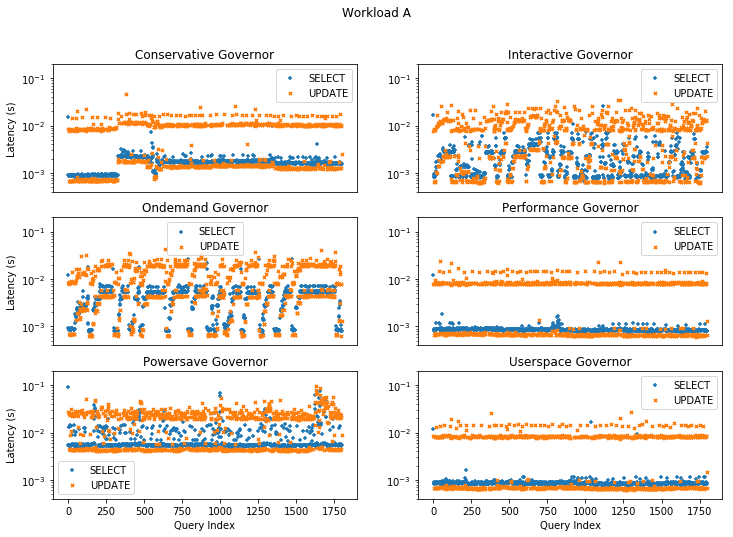

In [86]:
plot_workload_deltas(A_log_deltas, opsfiles[0], "Workload A", "workload_a_time_log_grid.pdf")

In [21]:
B_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadB_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [22]:
B_log_deltas = [compute_deltas(x[1]) for x in B_log_traces]

In [23]:
plot_workload_deltas(B_log_deltas, opsfiles[1], "Workload B", , "workload_b_time_log_grid.pdf")

SyntaxError: invalid syntax (<ipython-input-23-d37f383d7d53>, line 1)

In [ ]:
C_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadC_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [ ]:
C_log_deltas = [compute_deltas(x[1]) for x in C_log_traces]

In [ ]:
plot_workload_deltas(C_log_deltas, opsfiles[2], "Workload C", "workload_c_time_log_grid.pdf")

In [ ]:
D_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadD_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [ ]:
D_log_deltas = [compute_deltas(x[1]) for x in D_log_traces]

In [ ]:
plot_workload_deltas(D_log_deltas, opsfiles[3], "Workload D", "workload_d_time_log_grid.pdf")

In [96]:
E_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadE_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [97]:
E_log_deltas = [compute_deltas(x[1]) for x in E_log_traces]

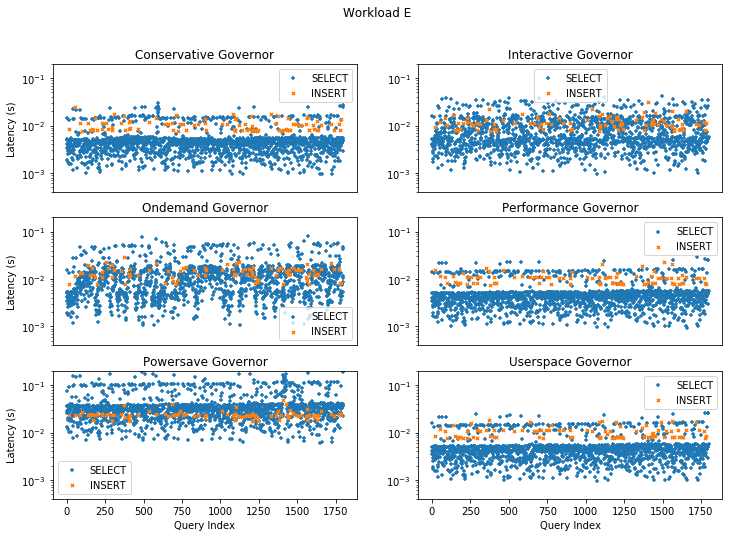

In [102]:
plot_workload_deltas(E_log_deltas, opsfiles[4], "Workload E", "workload_e_time_log_grid.pdf")

In [99]:
F_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadF_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [101]:
F_log_deltas = [compute_deltas(x[1]) for x in F_log_traces]

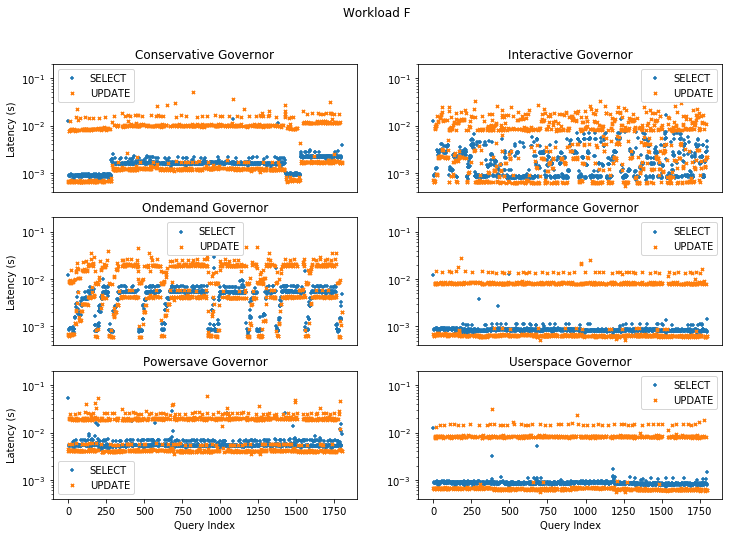

In [103]:
plot_workload_deltas(F_log_deltas, opsfiles[5], "Workload F", "workload_a_time_log_grid.pdf")

In [15]:
G_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadIB_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [16]:
G_log_deltas = [compute_deltas(x[1]) for x in G_log_traces]

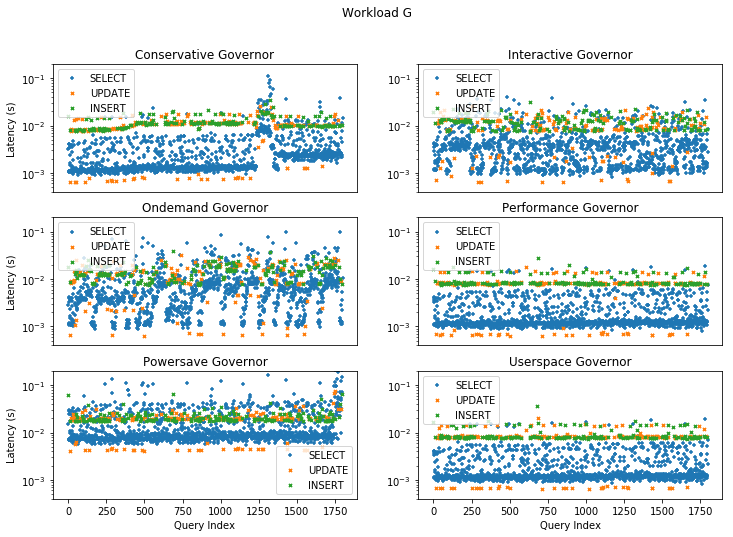

In [17]:
plot_workload_deltas(G_log_deltas, opsfiles[6], "Workload G")

In [18]:
H_log_traces = [ (gov, load_log(
    "../governor_traces/with_delaytags/log_"+gov+"/YCSB_WorkloadIC_TimingAsql.log.gz"
    )
   )
   for gov in all_governors
]

In [19]:
H_log_deltas = [compute_deltas(x[1]) for x in H_log_traces]

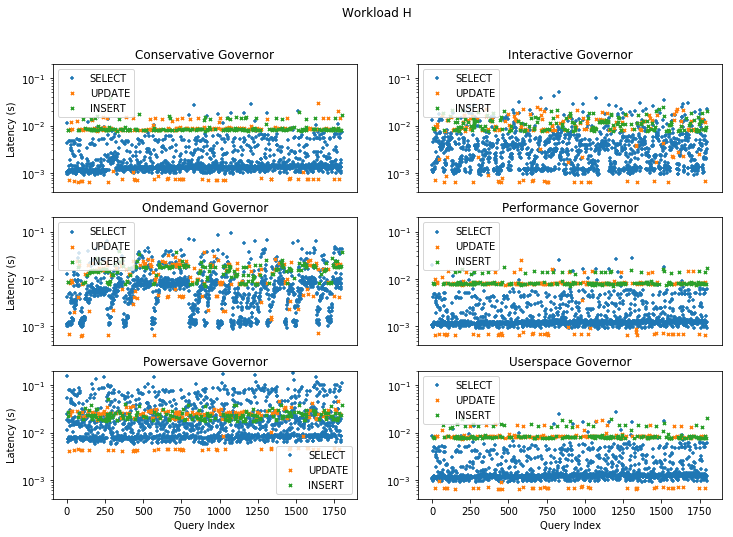

In [20]:
plot_workload_deltas(H_log_deltas, opsfiles[7], "Workload H")